# Baseline (Time-Frequency)

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
import tensorflow.keras.backend as K

import librosa
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import pickle
import argparse
import wandb
from wandb.keras import WandbCallback
wandb.init(project="COVID-19", name="Baseline")

parser = argparse.ArgumentParser(description="Baseline")
parser.add_argument('--sampling_rate', default=16000, type=int)
parser.add_argument('--top_db', default=60, type=int)
parser.add_argument('--feature', default="melspec", type=str) # melspec or mfcc 
parser.add_argument('--wav_aug', default=True, type=bool)
parser.add_argument('--spec_aug', default=True, type=bool)
parser.add_argument('--freq_mask', default=32, type=int) # 8, 16, 32
parser.add_argument('--time_mask', default=32, type=int) # 8, 16, 32
parser.add_argument('--n_freq_mask', default=1, type=int) # 1, 2
parser.add_argument('--n_time_mask', default=1, type=int) # 1, 2
parser.add_argument('--optimizer', default="sgd", type=str) # sgd or adam
parser.add_argument('--loss', default="fl", type=str) # bc or fl or fl_af
parser.add_argument('--learning_rate', default=0.001, type=float)
parser.add_argument('--batch_size', default=64, type=int)
parser.add_argument('--epochs', default=100, type=int)
parser.add_argument('--cv', default=10, type=int)
parser.add_argument('--ensemble', default="soft", type=str) # soft or hard
parser.add_argument('--seed', default=1011, type=int)
args = parser.parse_args('')

wandb.config.update(args)

sampling_rate = args.sampling_rate
top_db = args.top_db
feature = args.feature
wav_aug = args.wav_aug
spec_aug = args.spec_aug
freq_mask = args.freq_mask
time_mask = args.time_mask
n_freq_mask = args.n_freq_mask
n_time_mask = args.n_time_mask
optimizer = args.optimizer
loss = args.loss
learning_rate = args.learning_rate
BATCH_SIZE = args.batch_size
EPOCHS = args.epochs
cv = args.cv
ensemble = args.ensemble
seed = args.seed

def set_seeds(seed=seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
set_seeds()

with open(f'data/pkl/train_df_{sampling_rate}.pkl', 'rb') as f:
    train_df = pickle.load(f)
with open(f'data/pkl/test_df_{sampling_rate}.pkl', 'rb') as f:
    test_df = pickle.load(f)
    
train_df.head()

,data,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,24,female,0,1,0
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,51,male,0,0,0
2,"[2.7372453e-09, -1.0615647e-08, 5.2142607e-08,...",3,22,male,0,0,0
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,29,female,1,0,0
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,23,male,0,0,0


In [2]:
train_df["covid19"].value_counts(normalize=True)

0    0.91958
1    0.08042
Name: covid19, dtype: float64

## Data Generation

In [3]:
# train_df = pd.read_csv("data/train_data.csv")
# test_df = pd.read_csv("data/test_data.csv")
# unlabeled_df = pd.read_csv("data/unlabeled_data.csv")

# train_folder = "data/train/"
# test_folder = "data/test/"
# unlabeled_folder = "data/unlabeled/"

# def dataset(folder, df):
#     dataset = []
#     for uid in tqdm(df['id']):
#         path = os.path.join(folder, str(uid).zfill(5)+'.wav')
#         y, sr = librosa.load(path, sr=sampling_rate)
#         y = librosa.util.normalize(y)
#         dataset.append([y])
#     dataset = pd.DataFrame(dataset, columns=['data'])
#     dataset = pd.concat([dataset, df], axis=1)
#     return dataset

# train_df = dataset(train_folder, train_df)
# test_df = dataset(test_folder, test_df)
# unlabeled_df = dataset(unlabeled_folder, unlabeled_df)

# with open('train_df.pkl', 'wb') as f:
#     pickle.dump(train_df, f, pickle.HIGHEST_PROTOCOL)
# with open('test_df.pkl', 'wb') as f:
#     pickle.dump(test_df, f, pickle.HIGHEST_PROTOCOL)
# with open('unlabeled_df.pkl', 'wb') as f:
#     pickle.dump(unlabeled_df, f, pickle.HIGHEST_PROTOCOL)

## Preprocessing

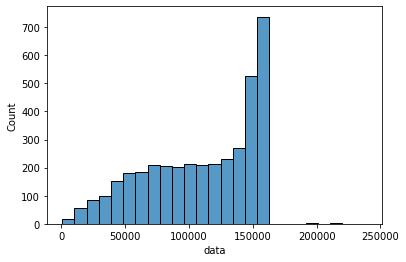

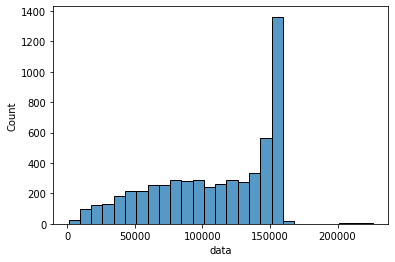

In [4]:
def trim_wav(data, top_db):
    
    frame_length = 0.025
    frame_stride = 0.010

    input_nfft = int(round(sampling_rate*frame_length))
    input_stride = int(round(sampling_rate*frame_stride))
    
    trim_data = data.apply(lambda x : librosa.effects.trim(x, top_db=top_db,
                                                           frame_length=input_nfft,
                                                           hop_length=input_stride)[0])
    return trim_data

train_df["data"] = trim_wav(train_df["data"], top_db)
test_df["data"] = trim_wav(test_df["data"], top_db)

sns.histplot(train_df["data"].apply(lambda x : len(x)))
plt.show()
sns.histplot(test_df["data"].apply(lambda x : len(x)))
plt.show()

In [5]:
def padding_wav(x, reqlen=156027):
    x_len = x.shape[0]
    if reqlen < x_len:
        max_offset = x_len - reqlen
        offset = np.random.randint(max_offset)
        x = x[offset:(reqlen+offset)]
        return x
    elif reqlen == x_len:
        return x
    else:
        total_diff = reqlen - x_len
        offset = np.random.randint(total_diff)
        left_pad = offset
        right_pad = total_diff - offset
        return np.pad(x, (left_pad, right_pad), 'wrap')
    
train_df["data"] = train_df["data"].apply(lambda x : padding_wav(x))
test_df["data"] = test_df["data"].apply(lambda x : padding_wav(x))
    
train_df["data"].apply(lambda x : len(x)).min(), train_df["data"].apply(lambda x : len(x)).max()

(156027, 156027)

In [6]:
def preprocess_dataset(data):

    frame_length = 0.025
    frame_stride = 0.010

    input_nfft = int(round(sampling_rate*frame_length))
    input_stride = int(round(sampling_rate*frame_stride))

    extracted_features = []
    for i in data:
        
        if feature == "mfcc":
            n_feature = 40
            S = librosa.feature.mfcc(y=i,
                                     sr=sampling_rate,
                                     n_mfcc=n_feature,
                                     n_fft=input_nfft,
                                     hop_length=input_stride)
            S_delta = librosa.feature.delta(S)
            S_delta2 = librosa.feature.delta(S, order=2)
            
        elif feature == "melspec":
            n_feature = 128
            S = librosa.feature.melspectrogram(y=i,
                                               sr=sampling_rate,
                                               n_mels=n_feature,
                                               n_fft=input_nfft,
                                               hop_length=input_stride)
            S = librosa.power_to_db(S, ref=np.max)
            S_delta = librosa.feature.delta(S)
            S_delta2 = librosa.feature.delta(S, order=2)
            
        S = np.stack((S, S_delta, S_delta2), axis=2)
        extracted_features.append(S)
        
    return np.array(extracted_features)

X_test = preprocess_dataset(test_df["data"])
X_test.shape

(5732, 40, 976, 3)

In [7]:
def preprocess_feature(df):
    temp = df.copy()
    temp["old"] = temp["age"].apply(lambda x : 1 if x>=65 else 0)
    temp["young"] = temp["age"].apply(lambda x : 1 if x<5 else 0)
    temp["gender_male"] = temp["gender"].apply(lambda x : 1 if x=="male" else 0)
    temp["gender_female"] = temp["gender"].apply(lambda x : 1 if x=="female" else 0)
    temp["gender_other"] = temp["gender"].apply(lambda x : 1 if x=="other" else 0)
    temp["condition1"] = temp["respiratory_condition"] + temp["fever_or_muscle_pain"]
    temp["condition2"] = temp["respiratory_condition"] * temp["fever_or_muscle_pain"]
    temp = temp.drop(["data", "id", "age", "gender"], axis=1)
    return temp

X_test_tab = preprocess_feature(test_df).values
X_test_tab.shape

(5732, 9)

In [8]:
wav_augment = Compose([
    # AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    # TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    # Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

def spec_augment(spec, T=time_mask, F=freq_mask, time_mask_num=n_time_mask, freq_mask_num=n_freq_mask):
    feat_size = spec.shape[0]
    seq_len = spec.shape[1]
    # freq mask
    for _ in range(freq_mask_num):
        f = np.random.uniform(low=0.0, high=F)
        f = int(f)
        f0 = random.randint(0, feat_size - f)
        spec[:, f0 : f0 + f] = 0
    # time mask
    for _ in range(time_mask_num):
        t = np.random.uniform(low=0.0, high=T)
        t = int(t)
        t0 = random.randint(0, seq_len - t)
        spec[t0 : t0 + t] = 0
    return spec

def augmentation(data):
    temp = data.copy()
    aug = []
    for i in temp:
        aug_ = spec_augment(i)
        aug.append(aug_)
    aug = np.array(aug)
    return aug

## Training

In [9]:
def se_block(input_feature, ratio=8):
    
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    
    se_feature = layers.GlobalAveragePooling2D()(input_feature)
    se_feature = layers.Reshape((1, 1, channel))(se_feature)
    se_feature = layers.Dense(channel // ratio,
                              activation='relu',
                              kernel_initializer='he_normal',
                              use_bias=True,
                              bias_initializer='zeros')(se_feature)
    se_feature = layers.Dense(channel,
                              activation='sigmoid',
                              kernel_initializer='he_normal',
                              use_bias=True,
                              bias_initializer='zeros')(se_feature)
    
    if K.image_data_format() == 'channels_first':
        se_feature = layers.Permute((3, 1, 2))(se_feature)
        
    se_feature = layers.multiply([input_feature, se_feature])
    
    return se_feature

In [10]:
def attention_block(cbam_feature, ratio=8):
    
    attention_channel = channel_attention(cbam_feature, ratio)
    attention_frequency = frequency_attention(cbam_feature, ratio)
    attention_time = time_attention(cbam_feature, ratio)
    
    attention_feature = layers.Add()([attention_channel,
                                      attention_frequency,
                                      attention_time])
    
    # attention_feature = layers.Concatenate()([attention_channel,
    #                                           attention_frequency,
    #                                           attention_time])
    
    return attention_feature

def channel_attention(input_feature, ratio=8):
    
    channel_axis = -1
    channel = input_feature.shape[channel_axis]
    
    shared_layer_one = layers.Dense(channel//ratio,
                                    activation='relu',
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')
    shared_layer_two = layers.Dense(channel,
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')

    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = layers.Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = layers.GlobalMaxPooling2D()(input_feature)
    max_pool = layers.Reshape((1,1,channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = layers.Add()([avg_pool,max_pool])
    cbam_feature = layers.Activation('sigmoid')(cbam_feature)
        
    return layers.multiply([input_feature, cbam_feature])

def frequency_attention(input_feature, ratio=8):
    
    frequency_axis = 1
    frequency = input_feature.shape[frequency_axis]
    
    shared_layer_one = layers.Dense(frequency//ratio,
                                    activation='relu',
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')
    shared_layer_two = layers.Dense(frequency,
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')

    
    freq_feature = layers.Permute((2, 3, 1))(input_feature)
    
    avg_pool = layers.GlobalAveragePooling2D()(freq_feature)
    avg_pool = layers.Reshape((1,1,frequency))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = layers.GlobalMaxPooling2D()(freq_feature)
    max_pool = layers.Reshape((1,1,frequency))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = layers.Add()([avg_pool,max_pool])
    cbam_feature = layers.Activation('sigmoid')(cbam_feature)
    
    output_feature = layers.multiply([freq_feature, cbam_feature])
        
    return layers.Permute((3, 1, 2))(output_feature)

def time_attention(input_feature, ratio=8):
    
    time_axis = 1
    time = input_feature.shape[time_axis]
    
    shared_layer_one = layers.Dense(time//ratio,
                                    activation='relu',
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')
    shared_layer_two = layers.Dense(time,
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')

    
    time_feature = layers.Permute((1, 3, 2))(input_feature)
    
    avg_pool = layers.GlobalAveragePooling2D()(time_feature)
    avg_pool = layers.Reshape((1,1,time))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = layers.GlobalMaxPooling2D()(time_feature)
    max_pool = layers.Reshape((1,1,time))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = layers.Add()([avg_pool,max_pool])
    cbam_feature = layers.Activation('sigmoid')(cbam_feature)
    
    output_feature = layers.multiply([time_feature, cbam_feature])
        
    return layers.Permute((1, 3, 2))(output_feature)

In [14]:
def baseline():
    
    inp = tf.keras.Input(shape=(X_test.shape[1], X_test.shape[2], 3))
    tab = tf.keras.Input(shape=(X_test_tab.shape[1],))
    y = layers.Dense(16, use_bias=False)(tab)
    
    x = layers.Conv2D(32, 3, 1, padding="same", kernel_initializer="he_normal")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, 3, 1, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    
    res = layers.Conv2D(64, 1, padding="same", kernel_initializer="he_normal")(x)
    res = layers.BatchNormalization()(res)
    
    x = layers.Conv2D(64, 3, 1, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 3, 1, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, res])
    x = layers.Activation('relu')(x)
    x = se_block(x)
    x = layers.MaxPooling2D()(x)
    
    res = layers.Conv2D(128, 1, padding="same", kernel_initializer="he_normal")(x)
    res = layers.BatchNormalization()(res)
    
    x = layers.Conv2D(128, 3, 1, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, 3, 1, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, res])
    x = layers.Activation('relu')(x)
    x = se_block(x)
    x = layers.MaxPooling2D()(x)
    
    res = layers.Conv2D(256, 1, padding="same", kernel_initializer="he_normal")(x)
    res = layers.BatchNormalization()(res)
    
    x = layers.Conv2D(256, 3, 1, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, 3, 1, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, res])
    x = layers.Activation('relu')(x)
    x = se_block(x)
    x = layers.MaxPooling2D()(x)
    
    res = layers.Conv2D(512, 1, padding="same", kernel_initializer="he_normal")(x)
    res = layers.BatchNormalization()(res)
    
    x = layers.Conv2D(512, 3, 1, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(512, 3, 1, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, res])
    x = layers.Activation('relu')(x)
    x = se_block(x)
    
    x = layers.Permute((2, 1, 3))(x)
    x = layers.Reshape((x.shape[1], -1))(x)
    
    x = layers.Bidirectional(layers.LSTM(64, dropout=0.2, return_sequences=True))(x)
    x = layers.LayerNormalization()(x)
    x = layers.Bidirectional(layers.LSTM(64, dropout=0.2))(x)
    x = layers.LayerNormalization()(x)
    
    x = layers.Reshape((-1, 1))(x)
    x = layers.Multiply()([x, y])
    x = layers.Flatten()(x)
    
    x = layers.Dense(512, activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Dropout(0.2)(x)
    oup = layers.Dense(1, activation="sigmoid")(x)
    
    model = tf.keras.Model(inputs=[inp, tab], outputs=oup)
    
    return model

model = baseline()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 40, 976, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_25 (Conv2D)             (None, 40, 976, 32)  896         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_25 (BatchN  (None, 40, 976, 32)  128        ['conv2d_25[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [ ]:
class ArcfaceLoss(tf.keras.losses.Loss):
    def __init__(self, margin1=1.0, margin2=0.5, margin3=0.0, scale=64.0, from_logits=True, label_smoothing=0, **kwargs):
        super(ArcfaceLoss, self).__init__(**kwargs)
        self.margin1, self.margin2, self.margin3, self.scale = margin1, margin2, margin3, scale
        self.from_logits, self.label_smoothing = from_logits, label_smoothing
        self.threshold = np.cos((np.pi - margin2) / margin1)
        self.theta_min = (-1 - margin3) * 2
        self.batch_labels_back_up = None
    def build(self, batch_size):
        self.batch_labels_back_up = tf.Variable(tf.zeros([batch_size], dtype="int64"), dtype="int64", trainable=False)
    def call(self, y_true, norm_logits):
        if self.batch_labels_back_up is not None:
            self.batch_labels_back_up.assign(tf.argmax(y_true, axis=-1))
        pick_cond = tf.where(y_true != 0)
        y_pred_vals = tf.gather_nd(norm_logits, pick_cond)
        if self.margin1 == 1.0 and self.margin2 == 0.0 and self.margin3 == 0.0:
            theta = y_pred_vals
        elif self.margin1 == 1.0 and self.margin3 == 0.0:
            theta = tf.cos(tf.acos(y_pred_vals) + self.margin2)
        else:
            theta = tf.cos(tf.acos(y_pred_vals) * self.margin1 + self.margin2) - self.margin3
        theta_valid = tf.where(y_pred_vals > self.threshold, theta, self.theta_min - theta)
        arcface_logits = tf.tensor_scatter_nd_update(norm_logits, pick_cond, theta_valid) * self.scale
        return tf.keras.losses.binary_crossentropy(y_true, arcface_logits, from_logits=self.from_logits, label_smoothing=self.label_smoothing)
    def get_config(self):
        config = super(ArcfaceLoss, self).get_config()
        config.update(
            {
                "margin1": self.margin1,
                "margin2": self.margin2,
                "margin3": self.margin3,
                "scale": self.scale,
                "from_logits": self.from_logits,
                "label_smoothing": self.label_smoothing,
            }
        )
        return config
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
val_acc = []
val_precision = []
val_recall = []
val_micro_f1 = []
val_macro_f1 = []
val_auroc = []
val_aupr = []

thresholds = []
predictions = []

idx=0

skf = StratifiedKFold(n_splits=cv)
for train_index, val_index in tqdm(skf.split(train_df, train_df["covid19"])):
    
    idx+=1

    X_train, X_val = train_df["data"][train_index], train_df["data"][val_index]
    y_train, y_val = train_df["covid19"][train_index], train_df["covid19"][val_index]
    
    if wav_aug == True:
        X_train = wav_augment(X_train.values, sampling_rate)
        print("wav_aug successed")
    
    X_tab = preprocess_feature(train_df).drop("covid19", axis=1).values
    X_train_tab = X_tab[train_index]
    X_val_tab = X_tab[val_index]
        
    X_train = preprocess_dataset(X_train)
    X_val = preprocess_dataset(X_val)
    
    if spec_aug == True:
        X_train = augmentation(X_train)
        print("spec_aug successed")
    
    train_ds = (
        tf.data.Dataset.from_tensor_slices(((X_train, X_train_tab), y_train))
        .shuffle(len(X_train))
        .batch(BATCH_SIZE)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

    val_ds = (
        tf.data.Dataset.from_tensor_slices(((X_val, X_val_tab), y_val))
        .batch(BATCH_SIZE)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

    model = baseline()

    lr = tf.keras.optimizers.schedules.CosineDecay(learning_rate, decay_steps=1000)
    if optimizer == "adam":
        optim = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == "sgd":
        optim = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        
    if loss == "bc":
        label_smoothing=0
        loss_function = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing)
    elif loss == "fl":
        loss_function = tfa.losses.SigmoidFocalCrossEntropy()
    elif loss == "fl_af":
        loss_function = [tfa.losses.SigmoidFocalCrossEntropy(), ArcfaceLoss()]

    model.compile(
        optimizer=optim,
        loss=loss_function,
        metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')]
    )
    
    checkpoint_filepath=f"load_model/{parser.description}_{idx}"

    checkpoint_callback = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_auroc',
            patience=5,
            mode='max',
            restore_best_weights=True,
        ),
        tf.keras.callbacks.ModelCheckpoint(
            checkpoint_filepath,
            monitor='val_auroc',
            save_best_only=True,
            save_weights_only=True,
            mode='max',
        )
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[checkpoint_callback, WandbCallback()],
    )

    max_f1 = 0
    threshold = 0
    for temp_threshold in np.linspace(0.05, 0.95, 37):
        temp_f1 = f1_score(y_val, np.where(model.predict(val_ds)>temp_threshold, 1, 0), average="macro")
        if temp_f1 > max_f1:
            max_f1 = temp_f1
            threshold = temp_threshold
    
    print(f"idx:{idx}, macro-f1:{max_f1}, threshold:{threshold}")

    val_acc.append(accuracy_score(y_val, np.where(model.predict(val_ds)>threshold, 1, 0)))
    val_precision.append(precision_score(y_val, np.where(model.predict(val_ds)>threshold, 1, 0)))
    val_recall.append(recall_score(y_val, np.where(model.predict(val_ds)>threshold, 1, 0)))
    val_micro_f1.append(f1_score(y_val, np.where(model.predict(val_ds)>threshold, 1, 0), average="micro"))
    val_macro_f1.append(max_f1)
    val_auroc.append(roc_auc_score(y_val, model.predict(val_ds)))
    val_aupr.append(average_precision_score(y_val, model.predict(val_ds), pos_label=0))     
     
    thresholds.append(threshold)
    predictions.append(model.predict([X_test, X_test_tab]))

val_acc_mean = np.mean(val_acc, axis=0)
val_precision_mean = np.mean(val_precision, axis=0)
val_recall_mean = np.mean(val_recall, axis=0)
val_micro_f1_mean = np.mean(val_micro_f1, axis=0)
val_macro_f1_mean = np.mean(val_macro_f1, axis=0)
val_auroc_mean = np.mean(val_auroc, axis=0)
val_aupr_mean = np.mean(val_aupr, axis=0)

print(f"validation_accuracy:{val_acc_mean}, validation_precision:{val_precision_mean}, validation_recall:{val_recall_mean}, validation_micro-f1:{val_micro_f1_mean}")
print(f"validation_macro-f1:{val_macro_f1_mean}, validation_auroc:{val_auroc_mean}, validation_aupr:{val_aupr_mean}")

wandb.log({
    'validation_accuracy': val_acc_mean,
    'validation_precision': val_precision_mean,
    'validation_recall': val_recall_mean,
    'validation_micro-f1': val_micro_f1_mean,
    'validation_macro-f1': val_macro_f1_mean,
    'validation_auroc': val_auroc_mean,
    'validation_aupr': val_aupr_mean
})

## Inference

In [ ]:
if ensemble=="hard":
    temp=[]
    for i, v in enumerate(thresholds):
        temp.append(np.where(predictions[i]>v, 1, 0))
    test_df["covid19"] = np.where(np.hstack(temp).sum(axis=1)>cv/2, 1, 0)

elif ensemble=="soft":
    threshold = np.mean(thresholds)
    test_df["covid19"] = np.where(np.mean(predictions, axis=0)>threshold, 1, 0)

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')
submission['covid19'] = test_df['covid19']
submission.to_csv('submission.csv', index=False)

test_df['covid19'].value_counts(normalize=True)

In [ ]:
sip = np.sum(train_df["covid19"].value_counts(normalize=True)[1]-test_df["covid19"].value_counts(normalize=True)[1])

print("Sum of Imbalanced Proportions: ", sip)
wandb.log({'Sum of Imbalanced Proportions': sip})